# Data Sanitization and Normalization

## Purpose
This notebook is designed to sanitize and normalize the chess database by removing inefficiencies, redundancies, and outliers that could negatively impact the quality of opening recommendations. The goal is to clean up the data while preserving the most valuable information for the chess opening recommender system.

## Key Areas of Focus
- **Redundant Opening Names**: Consolidate openings that share the same name but have different ECO codes
- **Data Inefficiencies**: Remove or consolidate records that provide minimal analytical value
- **Outliers**: Identify and handle extreme cases that might skew recommendations
- **Database Optimization**: Reduce storage footprint while maintaining data integrity

## Process Overview
1. **Baseline Analysis**: Establish current database statistics and size metrics
2. **Identify Redundancies**: Find opening names with multiple ECO codes
3. **Data Consolidation**: Merge redundant records while preserving statistical accuracy
4. **Quality Validation**: Verify that changes maintain data integrity
5. **Performance Optimization**: Measure improvements in database size and query performance

This systematic approach ensures that the database becomes more efficient and reliable for generating chess opening recommendations.

In [ ]:
# Configuration and setup
import pandas as pd
import os
from pathlib import Path
from utils.database.db_utils import get_db_connection

# Define the path to the DuckDB database file
project_root = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
db_path = project_root / "data" / "processed" / "chess_games.db"

# Set pandas display options for better readability
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Database path: {db_path}")
print(f"Database exists: {db_path.exists()}")

def log_database_statistics():
    """
    Log comprehensive database statistics including table sizes, record counts,
    file size, and key metrics. This function can be called repeatedly to track
    changes as we sanitize and normalize the data.
    """
    if not db_path.exists():
        print(f"Database file not found at {db_path}")
        return
    
    # Get database file size
    db_size_bytes = os.path.getsize(db_path)
    db_size_mb = db_size_bytes / (1024 * 1024)
    db_size_gb = db_size_mb / 1024
    
    with get_db_connection(db_path) as con:
        print("=" * 60)
        print("DATABASE STATISTICS SNAPSHOT")
        print("=" * 60)
        
        # File size information
        print(f"\n--- Database File Size ---")
        print(f"Size: {db_size_mb:,.1f} MB ({db_size_gb:.2f} GB)")
        print(f"Raw bytes: {db_size_bytes:,}")
        
        # Core table counts
        print(f"\n--- Core Tables ---")
        player_count = con.execute('SELECT COUNT(*) FROM player').fetchone()[0]
        opening_count = con.execute('SELECT COUNT(*) FROM opening').fetchone()[0]
        total_stats_records = con.execute('SELECT COUNT(*) FROM player_opening_stats').fetchone()[0]
        
        print(f"Players: {player_count:,}")
        print(f"Openings: {opening_count:,}")
        print(f"Player-Opening-Stats Records: {total_stats_records:,}")
        
        # Partition distribution
        print(f"\n--- Partition Distribution ---")
        partitions = ['A', 'B', 'C', 'D', 'E', 'other']
        total_partition_records = 0
        
        for partition in partitions:
            count = con.execute(f'SELECT COUNT(*) FROM player_opening_stats_{partition}').fetchone()[0]
            total_partition_records += count
            percentage = (count / total_stats_records * 100) if total_stats_records > 0 else 0
            print(f"  Partition {partition}: {count:,} ({percentage:.1f}%)")
        
        # Game statistics
        print(f"\n--- Game Statistics ---")
        total_games = con.execute("""
            SELECT SUM(num_wins + num_draws + num_losses) as total_games
            FROM player_opening_stats
        """).fetchone()[0]
        
        total_wins = con.execute('SELECT SUM(num_wins) FROM player_opening_stats').fetchone()[0]
        total_draws = con.execute('SELECT SUM(num_draws) FROM player_opening_stats').fetchone()[0]
        total_losses = con.execute('SELECT SUM(num_losses) FROM player_opening_stats').fetchone()[0]
        
        print(f"Total Games: {total_games:,}")
        print(f"  Wins: {total_wins:,} ({total_wins/total_games*100:.1f}%)")
        print(f"  Draws: {total_draws:,} ({total_draws/total_games*100:.1f}%)")
        print(f"  Losses: {total_losses:,} ({total_losses/total_games*100:.1f}%)")
        print(f"Average Games per Record: {total_games/total_stats_records:.1f}")
        
        # Color distribution
        print(f"\n--- Color Distribution ---")
        white_records = con.execute("SELECT COUNT(*) FROM player_opening_stats WHERE color = 'w'").fetchone()[0]
        black_records = con.execute("SELECT COUNT(*) FROM player_opening_stats WHERE color = 'b'").fetchone()[0]
        
        print(f"White Records: {white_records:,} ({white_records/total_stats_records*100:.1f}%)")
        print(f"Black Records: {black_records:,} ({black_records/total_stats_records*100:.1f}%)")
        
        # Opening name duplication check
        print(f"\n--- Opening Name Analysis ---")
        unique_names = con.execute('SELECT COUNT(DISTINCT name) FROM opening').fetchone()[0]
        duplicate_names_count = con.execute("""
            SELECT COUNT(*) FROM (
                SELECT name, COUNT(DISTINCT eco) as eco_count
                FROM opening
                GROUP BY name
                HAVING COUNT(DISTINCT eco) > 1
            ) duplicate_check
        """).fetchone()[0]
        
        print(f"Unique Opening Names: {unique_names:,}")
        print(f"Names with Multiple ECO Codes: {duplicate_names_count:,}")
        print(f"Name Duplication Rate: {duplicate_names_count/unique_names*100:.1f}%")
        
        # Storage efficiency metrics
        print(f"\n--- Storage Efficiency ---")
        bytes_per_record = db_size_bytes / total_stats_records if total_stats_records > 0 else 0
        bytes_per_game = db_size_bytes / total_games if total_games > 0 else 0
        
        print(f"Bytes per Stats Record: {bytes_per_record:.1f}")
        print(f"Bytes per Game: {bytes_per_game:.2f}")
        
        print("=" * 60)
        print("END STATISTICS SNAPSHOT")
        print("=" * 60)

# Log initial database state
log_database_statistics()

In [ ]:
# Find all opening names with multiple ECO codes (duplicated names)
# This replicates the analysis from notebook 21 to identify consolidation opportunities

if db_path.exists():
    with get_db_connection(db_path) as con:
        print("=== IDENTIFYING OPENING NAMES WITH MULTIPLE ECO CODES ===")
        print("This analysis will help us understand which openings can be consolidated.\n")
        
        # Find opening names that appear with multiple ECO codes
        duplicate_names_query = """
            SELECT 
                name,
                COUNT(DISTINCT eco) as eco_count,
                STRING_AGG(DISTINCT eco, ', ' ORDER BY eco) as eco_codes,
                COUNT(*) as total_opening_records,
                SUM(total_games) as combined_games,
                SUM(unique_players) as combined_players,
                SUM(stats_records) as total_stats_records
            FROM (
                SELECT 
                    o.name,
                    o.eco,
                    o.id as opening_id,
                    SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                    COUNT(DISTINCT pos.player_id) as unique_players,
                    COUNT(*) as stats_records
                FROM opening o
                JOIN player_opening_stats pos ON o.id = pos.opening_id
                GROUP BY o.id, o.name, o.eco
            ) stats
            GROUP BY name
            HAVING COUNT(DISTINCT eco) > 1
            ORDER BY eco_count DESC, combined_games DESC
        """
        
        duplicate_names_df = con.execute(duplicate_names_query).fetchdf()
        
        if len(duplicate_names_df) > 0:
            print(f"Found {len(duplicate_names_df)} opening names with multiple ECO codes:\n")
            
            # Format the summary display
            summary_display = duplicate_names_df.copy()
            summary_display['total_opening_records'] = summary_display['total_opening_records'].apply('{:,}'.format)
            summary_display['combined_games'] = summary_display['combined_games'].apply('{:,}'.format)
            summary_display['combined_players'] = summary_display['combined_players'].apply('{:,}'.format)
            summary_display['total_stats_records'] = summary_display['total_stats_records'].apply('{:,}'.format)
            
            # Rename columns for better display
            summary_display.columns = [
                'Opening Name', 'ECO Count', 'ECO Codes', 'Opening Records', 
                'Total Games', 'Total Players', 'Stats Records'
            ]
            
            print("--- SUMMARY OF ALL DUPLICATED OPENING NAMES ---")
            print(summary_display.to_string(index=False))
            
            # Store the raw data for use in subsequent cells
            duplicate_openings_raw = duplicate_names_df.copy()
            
            # Show detailed breakdown for top 10 most complex cases
            print(f"\n=== DETAILED BREAKDOWN FOR TOP 10 MOST COMPLEX CASES ===")
            print("This shows exactly which ECO codes belong to each duplicated name.\n")
            
            top_complex_names = duplicate_names_df.head(10)['name'].tolist()
            
            detailed_breakdowns = {}
            
            for i, name in enumerate(top_complex_names, 1):
                print(f"{i}. '{name}'")
                print("-" * (len(name) + 10))
                
                detailed_query = """
                    SELECT 
                        o.eco,
                        o.id as opening_id,
                        SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                        COUNT(DISTINCT pos.player_id) as unique_players,
                        COUNT(*) as stats_records,
                        -- White performance
                        SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as white_games,
                        ROUND(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                              NULLIF(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 1) as white_win_pct,
                        -- Black performance  
                        SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as black_games,
                        ROUND(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                              NULLIF(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 1) as black_win_pct
                    FROM opening o
                    JOIN player_opening_stats pos ON o.id = pos.opening_id
                    WHERE o.name = ?
                    GROUP BY o.id, o.eco
                    ORDER BY total_games DESC
                """
                
                breakdown_df = con.execute(detailed_query, [name]).fetchdf()
                detailed_breakdowns[name] = breakdown_df.copy()
                
                # Format for display
                breakdown_display = breakdown_df.copy()
                breakdown_display['total_games'] = breakdown_display['total_games'].apply('{:,}'.format)
                breakdown_display['unique_players'] = breakdown_display['unique_players'].apply('{:,}'.format)
                breakdown_display['stats_records'] = breakdown_display['stats_records'].apply('{:,}'.format)
                breakdown_display['white_games'] = breakdown_display['white_games'].apply('{:,}'.format)
                breakdown_display['black_games'] = breakdown_display['black_games'].apply('{:,}'.format)
                
                # Remove opening_id from display (keep for internal use)
                display_cols = ['eco', 'total_games', 'unique_players', 'stats_records', 
                               'white_games', 'white_win_pct', 'black_games', 'black_win_pct']
                breakdown_display = breakdown_display[display_cols]
                breakdown_display.columns = ['ECO', 'Total Games', 'Players', 'Stats Records',
                                           'White Games', 'White Win%', 'Black Games', 'Black Win%']
                
                print(breakdown_display.to_string(index=False))
                print()  # Empty line for readability
            
            # Calculate and display potential consolidation impact
            print("=== CONSOLIDATION IMPACT SUMMARY ===")
            
            total_duplicated_names = len(duplicate_names_df)
            total_affected_games = duplicate_names_df['combined_games'].sum()
            total_affected_players = duplicate_names_df['combined_players'].sum()
            total_opening_records = duplicate_names_df['total_opening_records'].sum()
            total_stats_records_affected = duplicate_names_df['total_stats_records'].sum()
            
            # Get overall database stats for percentages
            total_openings = con.execute('SELECT COUNT(*) FROM opening').fetchone()[0]
            total_all_stats_records = con.execute('SELECT COUNT(*) FROM player_opening_stats').fetchone()[0]
            
            opening_reduction = total_opening_records - total_duplicated_names
            opening_reduction_pct = (opening_reduction / total_openings * 100) if total_openings > 0 else 0
            
            print(f"Names with multiple ECO codes: {total_duplicated_names:,}")
            print(f"Total affected games: {total_affected_games:,}")
            print(f"Total affected players: {total_affected_players:,}")
            print(f"Opening table records affected: {total_opening_records:,}")
            print(f"Stats records affected: {total_stats_records_affected:,} ({total_stats_records_affected/total_all_stats_records*100:.1f}% of total)")
            print(f"\nPotential opening table reduction: {opening_reduction:,} records ({opening_reduction_pct:.1f}%)")
            print(f"Remaining openings after consolidation: {total_openings - opening_reduction:,}")
            
            # Store data for next cells
            print(f"\n✓ Data prepared for consolidation analysis in next cells")
            print(f"✓ Found {total_duplicated_names} opening names ready for potential consolidation")
            print(f"✓ Detailed breakdowns available for top {len(top_complex_names)} most complex cases")
            
        else:
            print("No opening names found with multiple ECO codes.")
            print("All opening names have unique ECO code assignments.")
            duplicate_openings_raw = pd.DataFrame()
            detailed_breakdowns = {}
    
else:
    print(f"Database file not found at {db_path}")
    duplicate_openings_raw = pd.DataFrame()
    detailed_breakdowns = {}

## Opening Popularity Analysis

Now that we've cleaned up the database, let's analyze which openings are most and least popular. This analysis helps us understand:
- Which openings have the most statistical significance
- Which openings might need more data
- Distribution patterns across the opening repertoire

We'll look at both the most-played and least-played openings to get a complete picture of the database coverage.

In [36]:
# Configuration for opening popularity analysis
# Adjust these variables to control how many results to display

# Number of most-played openings to show
TOP_N_MOST_PLAYED = 200

# Number of least-played openings to show
TOP_N_LEAST_PLAYED = 500

# Minimum games threshold for percentile analysis
MIN_GAMES_FOR_PERCENTILE = 50

print("=== OPENING POPULARITY ANALYSIS CONFIGURATION ===")
print(f"Most-played openings to display: {TOP_N_MOST_PLAYED}")
print(f"Least-played openings to display: {TOP_N_LEAST_PLAYED}")
print(f"Minimum games for percentile analysis: {MIN_GAMES_FOR_PERCENTILE}")
print(f"\nYou can modify these variables at the top of this cell to change the analysis scope.")


=== OPENING POPULARITY ANALYSIS CONFIGURATION ===
Most-played openings to display: 200
Least-played openings to display: 500
Minimum games for percentile analysis: 50

You can modify these variables at the top of this cell to change the analysis scope.


## Most-Played Openings

These are the openings with the highest number of total games across all players. These openings have the most statistical significance and are the most common in our database.

In [41]:
# Most-played openings by total number of games
if db_path.exists():
    with get_db_connection(db_path) as con:
        print(f"=== TOP {TOP_N_MOST_PLAYED} MOST-PLAYED OPENINGS BY TOTAL GAMES ===\n")
        
        most_played = con.execute(f"""
            SELECT 
                o.eco,
                o.name,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                COUNT(DISTINCT pos.player_id) as unique_players,
                -- Overall results
                SUM(pos.num_wins) as total_wins,
                SUM(pos.num_draws) as total_draws,
                SUM(pos.num_losses) as total_losses,
                -- White's performance
                COUNT(DISTINCT CASE WHEN pos.color = 'w' THEN pos.player_id END) as white_players,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) as white_wins,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_draws ELSE 0 END) as white_draws,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_losses ELSE 0 END) as white_losses,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as white_games,
                -- Black's performance
                COUNT(DISTINCT CASE WHEN pos.color = 'b' THEN pos.player_id END) as black_players,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) as black_wins,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_draws ELSE 0 END) as black_draws,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_losses ELSE 0 END) as black_losses,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as black_games,
                -- Win percentages by color
                ROUND(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                      NULLIF(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 2) as white_win_pct,
                ROUND(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                      NULLIF(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 2) as black_win_pct,
                -- Overall win percentage (from both colors)
                ROUND(SUM(pos.num_wins) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_win_pct,
                ROUND(SUM(pos.num_draws) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_draw_pct,
                ROUND(SUM(pos.num_losses) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_loss_pct
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id, o.eco, o.name
            ORDER BY total_games DESC
            LIMIT {TOP_N_MOST_PLAYED}
        """).fetchdf()
        
        # Format the display
        display_df = most_played.copy()
        
        # Format number columns with thousands separators
        for col in ['total_games', 'unique_players', 'total_wins', 'total_draws', 'total_losses',
                   'white_players', 'white_wins', 'white_draws', 'white_losses', 'white_games',
                   'black_players', 'black_wins', 'black_draws', 'black_losses', 'black_games']:
            display_df[col] = display_df[col].apply('{:,}'.format)
        
        # Rename columns for better display
        display_df.columns = [
            'ECO', 'Opening Name', 'Total Games', 'Unique Players',
            'Total Wins', 'Total Draws', 'Total Losses',
            'White Players', 'White Wins', 'White Draws', 'White Losses', 'White Games',
            'Black Players', 'Black Wins', 'Black Draws', 'Black Losses', 'Black Games',
            'White Win %', 'Black Win %', 'Overall Win %', 'Overall Draw %', 'Overall Loss %'
        ]
        
        print(display_df.to_string(index=False))
        
        # Summary statistics
        total_games_in_results = most_played['total_games'].sum()
        avg_games_per_opening = most_played['total_games'].mean()
        median_games_per_opening = most_played['total_games'].median()
        avg_players_per_opening = most_played['unique_players'].mean()
        median_players_per_opening = most_played['unique_players'].median()
        
        print(f"\n--- Summary Statistics for Top {TOP_N_MOST_PLAYED} Most-Played Openings ---")
        print(f"Total games in these openings: {total_games_in_results:,}")
        print(f"Average games per opening: {avg_games_per_opening:,.1f}")
        print(f"Median games per opening: {median_games_per_opening:,.1f}")
        print(f"Min games: {most_played['total_games'].min():,}")
        print(f"Max games: {most_played['total_games'].max():,}")
        print(f"\nAverage unique players per opening: {avg_players_per_opening:,.1f}")
        print(f"Median unique players per opening: {median_players_per_opening:,.1f}")
        print(f"Min players: {most_played['unique_players'].min():,}")
        print(f"Max players: {most_played['unique_players'].max():,}")
        
        # Overall database perspective
        total_games_db = con.execute('SELECT SUM(num_wins + num_draws + num_losses) FROM player_opening_stats').fetchone()[0]
        percentage_of_total = (total_games_in_results / total_games_db * 100) if total_games_db > 0 else 0
        
        print(f"\nThese {TOP_N_MOST_PLAYED} openings represent {percentage_of_total:.1f}% of all games in the database")
else:
    print(f"Database file not found at {db_path}")

=== TOP 200 MOST-PLAYED OPENINGS BY TOTAL GAMES ===



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ECO                                                     Opening Name  Total Games Unique Players  Total Wins Total Draws Total Losses White Players  White Wins White Draws White Losses White Games Black Players  Black Wins Black Draws Black Losses Black Games  White Win %  Black Win %  Overall Win %  Overall Draw %  Overall Loss %
C41                                                 Philidor Defense 11,806,290.0         43,817 5,632,378.0   546,072.0  5,627,840.0        36,649 2,334,875.0   212,256.0  2,094,847.0 4,641,978.0        32,761 3,297,503.0   333,816.0  3,532,993.0 7,164,312.0        50.30        46.03          47.71            4.63           47.67
B06                                                   Modern Defense 10,874,216.0         48,622 5,184,809.0   484,780.0  5,204,627.0        47,215 2,603,782.0   237,210.0  2,507,602.0 5,348,594.0        25,056 2,581,027.0   247,570.0  2,697,025.0 5,525,622.0        48.68        46.71          47.68            4.46           47.86
B

## Delete Overly Generic Openings

This cell deletes specific openings that are too generic or broad to provide meaningful recommendations. These openings (like "Sicilian Defense" without a specific variation) are parent categories that don't give players actionable insights.

The deletion process uses **separate transactions** for each opening to avoid foreign key violations:
1. **Transaction 1**: Delete all `player_opening_stats` entries from all partitioned tables for this opening
2. **Verification**: Confirm no stats remain for this opening
3. **Transaction 2**: Delete the opening from the `opening` table

This two-phase approach ensures clean deletion without foreign key constraint violations.

Each opening is logged individually with pre- and post-deletion statistics. Any openings not found in the database will be reported (may indicate typos in ECO code or name).

In [ ]:
# Delete specified generic openings using two-phase transaction approach
# Testing with first 3 openings to validate the approach

if db_path.exists():
    # Define openings to delete (starting with first 3)
    openings_to_delete = [
        ("D00", "Queen's Pawn Game"),
        ("A40", "Horwitz Defense"),
        ("A00", "Van't Kruijs Opening"),
        ("A45", "Indian Defense"),
        ("B30", "Sicilian Defense: Old Sicilian"),
        ("C23", "Bishop's Opening"),
        ("D02", "Queen's Pawn Game: Zukertort Variation"),
        ("D02", "Queen's Pawn Game: Chigorin Variation"),
        ("C20", "King's Pawn Game: Leonardis Variation"),
        ("B20", "Sicilian Defense"),
        ("C01", "French Defense: Exchange Variation"),
        ("C00", "French Defense: Normal Variation"),
        ("B13", "Caro-Kann Defense: Exchange Variation"),
        ("D30", "Queen's Gambit Declined"),
        ("B50", "Sicilian Defense: Modern Variations"),
        ("C00", "French Defense"),
        ("B23", "Sicilian Defense: Closed, Traditional"),
        ("C50", "Italian Game"),
        ("A41", "Old Indian Defense"),
        ("A10", "English Opening"),
        ("C20", "Center Game"),
        ("A05", "Zukertort Opening"),
        ("D02", "Queen's Pawn Game: Symmetrical Variation"),
        ("A30", "English Opening: Symmetrical Variation"),
        ("C20", "King's Pawn Game"),
    ]
    
    print("=" * 80)
    print("DELETING OVERLY GENERIC OPENINGS - TWO-PHASE TRANSACTION APPROACH")
    print("=" * 80)
    print(f"\nProcessing {len(openings_to_delete)} openings...")
    print("Each opening will be deleted in two separate transactions:")
    print("  1. Delete all player_opening_stats entries")
    print("  2. Delete the opening from the opening table")
    print()
    
    # Log database state before deletion
    print("\n" + "=" * 80)
    print("DATABASE STATE BEFORE DELETION")
    print("=" * 80)
    log_database_statistics()
    
    # Track results
    openings_successfully_deleted = []
    openings_not_found = []
    openings_with_errors = []
    
    # Define partition letters
    partition_letters = ['A', 'B', 'C', 'D', 'E', 'other']
    
    # Process each opening with separate transactions
    for eco, name in openings_to_delete:
        print("\n" + "=" * 80)
        print(f"PROCESSING: {eco} - {name}")
        print("=" * 80)
        
        try:
            # PHASE 1: Find and delete player_opening_stats
            # Open a fresh connection for this phase
            con = get_db_connection(db_path)
            
            # First, find the opening_id
            opening_result = con.execute("""
                SELECT id, eco, name 
                FROM opening 
                WHERE eco = ? AND name = ?
            """, [eco, name]).fetchone()
            
            if opening_result is None:
                print(f"⚠️  Opening not found in database: {eco} - {name}")
                print(f"    This may be a typo in the ECO code or name.")
                openings_not_found.append((eco, name))
                con.close()
                continue
            
            opening_id = opening_result[0]
            found_eco = opening_result[1]
            found_name = opening_result[2]
            
            print(f"✓ Found opening in database:")
            print(f"  - Opening ID: {opening_id}")
            print(f"  - ECO: {found_eco}")
            print(f"  - Name: {found_name}")
            
            # Count stats before deletion
            total_stats_before = 0
            partition_stats_before = {}
            
            for letter in partition_letters:
                partition_table = f"player_opening_stats_{letter}"
                count = con.execute(f"""
                    SELECT COUNT(*) 
                    FROM {partition_table} 
                    WHERE opening_id = ?
                """, [opening_id]).fetchone()[0]
                partition_stats_before[letter] = count
                total_stats_before += count
            
            print(f"\n📊 Player stats before deletion: {total_stats_before:,} total records")
            if total_stats_before > 0:
                print(f"    Distribution across partitions:")
                for letter in partition_letters:
                    if partition_stats_before[letter] > 0:
                        print(f"      - Partition {letter}: {partition_stats_before[letter]:,}")
            
            # TRANSACTION 1: Delete all player_opening_stats for this opening
            print(f"\n🗑️  TRANSACTION 1: Deleting player_opening_stats entries...")
            
            con.execute("BEGIN TRANSACTION")
            
            total_deleted = 0
            for letter in partition_letters:
                if partition_stats_before[letter] > 0:
                    partition_table = f"player_opening_stats_{letter}"
                    con.execute(f"""
                        DELETE FROM {partition_table}
                        WHERE opening_id = ?
                    """, [opening_id])
                    print(f"  ✓ Deleted {partition_stats_before[letter]:,} records from partition {letter}")
                    total_deleted += partition_stats_before[letter]
            
            con.execute("COMMIT")
            print(f"  ✅ Transaction 1 complete: {total_deleted:,} stats records deleted and committed")
            
            # VERIFICATION: Ensure all stats are deleted
            print(f"\n🔍 VERIFICATION: Checking for remaining stats...")
            remaining_stats = 0
            for letter in partition_letters:
                partition_table = f"player_opening_stats_{letter}"
                count = con.execute(f"""
                    SELECT COUNT(*) 
                    FROM {partition_table} 
                    WHERE opening_id = ?
                """, [opening_id]).fetchone()[0]
                if count > 0:
                    print(f"  ⚠️  WARNING: Found {count} remaining records in partition {letter}")
                    remaining_stats += count
            
            if remaining_stats > 0:
                print(f"  ❌ VERIFICATION FAILED: {remaining_stats} stats records still exist!")
                print(f"     Skipping opening deletion for safety.")
                openings_with_errors.append((eco, name, f"Stats verification failed: {remaining_stats} records remain"))
                con.close()
                continue
            else:
                print(f"  ✅ VERIFICATION PASSED: No stats records remain for opening_id {opening_id}")
            
            # Close the connection to end this transaction phase
            con.close()
            
            # PHASE 2: Delete the opening from the opening table
            # Open a completely new connection for this phase
            con2 = get_db_connection(db_path)
            
            print(f"\n🗑️  TRANSACTION 2: Deleting opening from opening table...")
            
            # Verify opening still exists before deletion
            verify_opening = con2.execute("""
                SELECT COUNT(*) 
                FROM opening 
                WHERE id = ?
            """, [opening_id]).fetchone()[0]
            
            if verify_opening == 0:
                print(f"  ⚠️  Opening {opening_id} not found in opening table")
                openings_with_errors.append((eco, name, "Opening not found before deletion"))
                con2.close()
                continue
            
            con2.execute("BEGIN TRANSACTION")
            
            con2.execute("""
                DELETE FROM opening
                WHERE id = ?
            """, [opening_id])
            
            con2.execute("COMMIT")
            print(f"  ✅ Transaction 2 complete: Opening deleted from opening table")
            
            # Final verification
            final_check = con2.execute("""
                SELECT COUNT(*) 
                FROM opening 
                WHERE id = ?
            """, [opening_id]).fetchone()[0]
            
            if final_check == 0:
                print(f"\n✅ SUCCESS: Opening {eco} - {name} completely removed from database")
                openings_successfully_deleted.append((eco, name, total_deleted))
            else:
                print(f"\n❌ ERROR: Opening still exists after deletion!")
                openings_with_errors.append((eco, name, "Opening still exists after deletion"))
            
            con2.close()
            
        except Exception as e:
            print(f"\n❌ ERROR processing {eco} - {name}: {str(e)}")
            openings_with_errors.append((eco, name, str(e)))
            try:
                con.close()
            except:
                pass
            try:
                con2.close()
            except:
                pass
    
    # Summary of deletion operation
    print("\n" + "=" * 80)
    print("DELETION OPERATION SUMMARY")
    print("=" * 80)
    
    print(f"\n✅ Successfully deleted: {len(openings_successfully_deleted)} openings")
    if openings_successfully_deleted:
        total_stats_deleted = sum([stats for _, _, stats in openings_successfully_deleted])
        print(f"   Total stats records deleted: {total_stats_deleted:,}")
        for eco, name, stats in openings_successfully_deleted:
            print(f"   - {eco}: {name} ({stats:,} stats records)")
    
    print(f"\n⚠️  Not found: {len(openings_not_found)} openings")
    if openings_not_found:
        print("   These may be typos in ECO code or name:")
        for eco, name in openings_not_found:
            print(f"   - {eco}: {name}")
    
    print(f"\n❌ Errors: {len(openings_with_errors)} openings")
    if openings_with_errors:
        for eco, name, error in openings_with_errors:
            print(f"   - {eco}: {name}")
            print(f"     Error: {error}")
    
    # Log database state after deletion
    print("\n" + "=" * 80)
    print("DATABASE STATE AFTER DELETION")
    print("=" * 80)
    log_database_statistics()
    
else:
    print(f"Database file not found at {db_path}")

## Least-Played Openings

These are the openings with the fewest number of total games. These might have insufficient data for reliable recommendations and could be candidates for filtering or consolidation.

In [44]:
# Least-played openings by total number of games
if db_path.exists():
    with get_db_connection(db_path) as con:
        print(f"=== TOP {TOP_N_LEAST_PLAYED} LEAST-PLAYED OPENINGS BY TOTAL GAMES ===\n")
        
        least_played = con.execute(f"""
            SELECT 
                o.eco,
                o.name,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                COUNT(DISTINCT pos.player_id) as unique_players,
                -- Overall results
                SUM(pos.num_wins) as total_wins,
                SUM(pos.num_draws) as total_draws,
                SUM(pos.num_losses) as total_losses,
                -- White's performance
                COUNT(DISTINCT CASE WHEN pos.color = 'w' THEN pos.player_id END) as white_players,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) as white_wins,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_draws ELSE 0 END) as white_draws,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_losses ELSE 0 END) as white_losses,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as white_games,
                -- Black's performance
                COUNT(DISTINCT CASE WHEN pos.color = 'b' THEN pos.player_id END) as black_players,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) as black_wins,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_draws ELSE 0 END) as black_draws,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_losses ELSE 0 END) as black_losses,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as black_games,
                -- Win percentages by color
                ROUND(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                      NULLIF(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 2) as white_win_pct,
                ROUND(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                      NULLIF(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 2) as black_win_pct,
                -- Overall win percentage (from both colors)
                ROUND(SUM(pos.num_wins) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_win_pct,
                ROUND(SUM(pos.num_draws) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_draw_pct,
                ROUND(SUM(pos.num_losses) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_loss_pct
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id, o.eco, o.name
            ORDER BY unique_players ASC
            LIMIT {TOP_N_LEAST_PLAYED}
        """).fetchdf()
        
        # Format the display
        display_df = least_played.copy()
        
        # Format number columns with thousands separators
        for col in ['total_games', 'unique_players', 'total_wins', 'total_draws', 'total_losses',
                   'white_players', 'white_wins', 'white_draws', 'white_losses', 'white_games',
                   'black_players', 'black_wins', 'black_draws', 'black_losses', 'black_games']:
            display_df[col] = display_df[col].apply('{:,}'.format)
        
        # Rename columns for better display
        display_df.columns = [
            'ECO', 'Opening Name', 'Total Games', 'Unique Players',
            'Total Wins', 'Total Draws', 'Total Losses',
            'White Players', 'White Wins', 'White Draws', 'White Losses', 'White Games',
            'Black Players', 'Black Wins', 'Black Draws', 'Black Losses', 'Black Games',
            'White Win %', 'Black Win %', 'Overall Win %', 'Overall Draw %', 'Overall Loss %'
        ]
        
        print(display_df.to_string(index=False))
        
        # Summary statistics
        total_games_in_results = least_played['total_games'].sum()
        avg_games_per_opening = least_played['total_games'].mean()
        median_games_per_opening = least_played['total_games'].median()
        avg_players_per_opening = least_played['unique_players'].mean()
        median_players_per_opening = least_played['unique_players'].median()
        
        print(f"\n--- Summary Statistics for Top {TOP_N_LEAST_PLAYED} Least-Played Openings ---")
        print(f"Total games in these openings: {total_games_in_results:,}")
        print(f"Average games per opening: {avg_games_per_opening:,.1f}")
        print(f"Median games per opening: {median_games_per_opening:,.1f}")
        print(f"Min games: {least_played['total_games'].min():,}")
        print(f"Max games: {least_played['total_games'].max():,}")
        print(f"\nAverage unique players per opening: {avg_players_per_opening:,.1f}")
        print(f"Median unique players per opening: {median_players_per_opening:,.1f}")
        print(f"Min players: {least_played['unique_players'].min():,}")
        print(f"Max players: {least_played['unique_players'].max():,}")
        
        # Overall database perspective
        total_games_db = con.execute('SELECT SUM(num_wins + num_draws + num_losses) FROM player_opening_stats').fetchone()[0]
        percentage_of_total = (total_games_in_results / total_games_db * 100) if total_games_db > 0 else 0
        
        print(f"\nThese {TOP_N_LEAST_PLAYED} openings represent {percentage_of_total:.2f}% of all games in the database")
else:
    print(f"Database file not found at {db_path}")

=== TOP 500 LEAST-PLAYED OPENINGS BY TOTAL GAMES ===



=== TOP 500 LEAST-PLAYED OPENINGS BY TOTAL GAMES ===



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

=== TOP 500 LEAST-PLAYED OPENINGS BY TOTAL GAMES ===



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ECO                                                                                        Opening Name Total Games Unique Players Total Wins Total Draws Total Losses White Players White Wins White Draws White Losses White Games Black Players Black Wins Black Draws Black Losses Black Games  White Win %  Black Win %  Overall Win %  Overall Draw %  Overall Loss %
B69              Sicilian Defense: Richter-Rauzer Variation, Neo-Modern Variation, Nyezhmetdinov Attack       372.0             80      172.0        26.0        174.0            51       92.0        13.0         75.0       180.0            32       80.0        13.0         99.0       192.0        51.11        41.67          46.24            6.99           46.77
B06                                                    Pterodactyl Defense: Fianchetto, Rhamphorhynchus       109.0             81       51.0         5.0         53.0            25       15.0         4.0         23.0        42.0            56       36.0         1.0       

## Delete Rare Openings

This cell deletes openings that have insufficient data for reliable recommendations:
- **Less than 100 total games** (insufficient statistical significance)
- **Less than 80 unique players** (insufficient diversity)

These openings don't provide enough data for the recommender system to make confident suggestions.

### Two-Phase Deletion Process:
1. **Phase 1**: Delete all `player_opening_stats` entries from all partitions for qualifying openings
2. **Verification**: Confirm no stats remain
3. **Phase 2**: Delete the openings from the `opening` table

This approach prevents foreign key violations and ensures clean deletion.

In [ ]:
# Verify deletion by showing new least-played openings
if db_path.exists():
    with get_db_connection(db_path) as con:
        print("=" * 80)
        print(f"VERIFICATION: NEW TOP {TOP_N_LEAST_PLAYED} LEAST-PLAYED OPENINGS")
        print("=" * 80)
        print("\nThese should all have at least 50 games AND at least 30 players\n")
        
        least_played_after = con.execute(f"""
            SELECT 
                o.eco,
                o.name,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                COUNT(DISTINCT pos.player_id) as unique_players,
                -- Overall results
                SUM(pos.num_wins) as total_wins,
                SUM(pos.num_draws) as total_draws,
                SUM(pos.num_losses) as total_losses,
                -- White's performance
                COUNT(DISTINCT CASE WHEN pos.color = 'w' THEN pos.player_id END) as white_players,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) as white_wins,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_draws ELSE 0 END) as white_draws,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_losses ELSE 0 END) as white_losses,
                SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as white_games,
                -- Black's performance
                COUNT(DISTINCT CASE WHEN pos.color = 'b' THEN pos.player_id END) as black_players,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) as black_wins,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_draws ELSE 0 END) as black_draws,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_losses ELSE 0 END) as black_losses,
                SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END) as black_games,
                -- Win percentages by color
                ROUND(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                      NULLIF(SUM(CASE WHEN pos.color = 'w' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 2) as white_win_pct,
                ROUND(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins ELSE 0 END) * 100.0 / 
                      NULLIF(SUM(CASE WHEN pos.color = 'b' THEN pos.num_wins + pos.num_draws + pos.num_losses ELSE 0 END), 0), 2) as black_win_pct,
                -- Overall win percentage (from both colors)
                ROUND(SUM(pos.num_wins) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_win_pct,
                ROUND(SUM(pos.num_draws) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_draw_pct,
                ROUND(SUM(pos.num_losses) * 100.0 / 
                      NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as overall_loss_pct
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id, o.eco, o.name
            ORDER BY total_games ASC
            LIMIT {TOP_N_LEAST_PLAYED}
        """).fetchdf()
        
        # Format the display
        display_df = least_played_after.copy()
        
        # Format number columns with thousands separators
        for col in ['total_games', 'unique_players', 'total_wins', 'total_draws', 'total_losses',
                   'white_players', 'white_wins', 'white_draws', 'white_losses', 'white_games',
                   'black_players', 'black_wins', 'black_draws', 'black_losses', 'black_games']:
            display_df[col] = display_df[col].apply('{:,}'.format)
        
        # Rename columns for better display
        display_df.columns = [
            'ECO', 'Opening Name', 'Total Games', 'Unique Players',
            'Total Wins', 'Total Draws', 'Total Losses',
            'White Players', 'White Wins', 'White Draws', 'White Losses', 'White Games',
            'Black Players', 'Black Wins', 'Black Draws', 'Black Losses', 'Black Games',
            'White Win %', 'Black Win %', 'Overall Win %', 'Overall Draw %', 'Overall Loss %'
        ]
        
        print(display_df.to_string(index=False))
        
        # Summary statistics
        total_games_in_results = least_played_after['total_games'].sum()
        avg_games_per_opening = least_played_after['total_games'].mean()
        median_games_per_opening = least_played_after['total_games'].median()
        avg_players_per_opening = least_played_after['unique_players'].mean()
        median_players_per_opening = least_played_after['unique_players'].median()
        min_games = least_played_after['total_games'].min()
        min_players = least_played_after['unique_players'].min()
        
        print(f"\n--- Summary Statistics for New Least-Played Openings ---")
        print(f"Total games in these openings: {total_games_in_results:,}")
        print(f"Average games per opening: {avg_games_per_opening:,.1f}")
        print(f"Median games per opening: {median_games_per_opening:,.1f}")
        print(f"Min games: {min_games:,} (should be ≥ 50 OR player count ≥ 30)")
        print(f"Max games: {least_played_after['total_games'].max():,}")
        print(f"\nAverage unique players per opening: {avg_players_per_opening:,.1f}")
        print(f"Median unique players per opening: {median_players_per_opening:,.1f}")
        print(f"Min players: {min_players:,} (should be ≥ 30 OR game count ≥ 50)")
        print(f"Max players: {least_played_after['unique_players'].max():,}")
        
        # Verify criteria
        print(f"\n--- Deletion Criteria Verification ---")
        below_threshold = least_played_after[
            (least_played_after['total_games'] < 50) & 
            (least_played_after['unique_players'] < 30)
        ]
        
        if len(below_threshold) > 0:
            print(f"❌ WARNING: Found {len(below_threshold)} openings still below BOTH thresholds!")
            for idx, row in below_threshold.iterrows():
                print(f"   {row['eco']}: {row['name']} | Games: {row['total_games']} | Players: {row['unique_players']}")
        else:
            print(f"✅ All remaining openings meet at least one criterion:")
            print(f"   - Have ≥ 50 games, OR")
            print(f"   - Have ≥ 30 players")
            
            # Show how many meet each criterion
            meets_games = len(least_played_after[least_played_after['total_games'] >= 50])
            meets_players = len(least_played_after[least_played_after['unique_players'] >= 30])
            meets_both = len(least_played_after[
                (least_played_after['total_games'] >= 50) & 
                (least_played_after['unique_players'] >= 30)
            ])
            
            print(f"\n   Distribution:")
            print(f"   - Meet games threshold (≥ 50): {meets_games:,}")
            print(f"   - Meet players threshold (≥ 30): {meets_players:,}")
            print(f"   - Meet both thresholds: {meets_both:,}")
        
else:
    print(f"Database file not found at {db_path}")

## Highest scoring openings

Display the highest scoring openings for white and black.

In [51]:
# Get highest scoring openings by win percentage
if db_path.exists():
    with get_db_connection(db_path) as con:
        TOP_N_HIGHEST_SCORING = 50  # Number of top openings to show
        
        print(f"=== TOP {TOP_N_HIGHEST_SCORING} HIGHEST SCORING OPENINGS BY WIN PERCENTAGE ===\n")
        print("NOTE: No minimum thresholds applied - results may include openings with low game/player counts\n")
        
        # Get top openings as White
        print(f"--- Top {TOP_N_HIGHEST_SCORING} Openings as White (sorted by win rate) ---\n")
        
        white_results = con.execute(f"""
            SELECT 
                o.eco,
                o.name,
                SUM(pos.num_wins) as total_wins_as_white,
                SUM(pos.num_draws) as total_draws_as_white,
                SUM(pos.num_losses) as total_losses_as_white,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games_as_white,
                ROUND(100.0 * SUM(pos.num_wins) / NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as white_win_rate,
                COUNT(DISTINCT pos.player_id) as unique_players_as_white
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            WHERE pos.color = 'w'
            GROUP BY o.id, o.eco, o.name
            ORDER BY white_win_rate DESC
            LIMIT {TOP_N_HIGHEST_SCORING}
        """).fetchdf()
        
        # Format and display White results
        white_display = white_results.copy()
        for col in ['total_wins_as_white', 'total_draws_as_white', 'total_losses_as_white', 
                   'total_games_as_white', 'unique_players_as_white']:
            white_display[col] = white_display[col].apply('{:,}'.format)
        
        white_display.columns = ['ECO', 'Opening Name', 'Wins', 'Draws', 'Losses', 
                                'Total Games', 'Win Rate %', 'Players']
        print(white_display.to_string(index=True))
        
        # Summary stats for White
        print(f"\n--- White Opening Summary ---")
        print(f"Average win rate: {white_results['white_win_rate'].mean():.2f}%")
        print(f"Highest win rate: {white_results['white_win_rate'].max():.2f}% ({white_results.iloc[0]['name']})")
        print(f"Lowest win rate in top {TOP_N_HIGHEST_SCORING}: {white_results['white_win_rate'].min():.2f}%")
        print(f"Average games per opening: {white_results['total_games_as_white'].mean():.0f}")
        print(f"Average players per opening: {white_results['unique_players_as_white'].mean():.0f}")
        print(f"Total games represented: {white_results['total_games_as_white'].sum():,}")
        
        # Get top openings as Black
        print(f"\n\n--- Top {TOP_N_HIGHEST_SCORING} Openings as Black (sorted by win rate) ---\n")
        
        black_results = con.execute(f"""
            SELECT 
                o.eco,
                o.name,
                SUM(pos.num_wins) as total_wins_as_black,
                SUM(pos.num_draws) as total_draws_as_black,
                SUM(pos.num_losses) as total_losses_as_black,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games_as_black,
                ROUND(100.0 * SUM(pos.num_wins) / NULLIF(SUM(pos.num_wins + pos.num_draws + pos.num_losses), 0), 2) as black_win_rate,
                COUNT(DISTINCT pos.player_id) as unique_players_as_black
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            WHERE pos.color = 'b'
            GROUP BY o.id, o.eco, o.name
            ORDER BY black_win_rate DESC
            LIMIT {TOP_N_HIGHEST_SCORING}
        """).fetchdf()
        
        # Format and display Black results
        black_display = black_results.copy()
        for col in ['total_wins_as_black', 'total_draws_as_black', 'total_losses_as_black', 
                   'total_games_as_black', 'unique_players_as_black']:
            black_display[col] = black_display[col].apply('{:,}'.format)
        
        black_display.columns = ['ECO', 'Opening Name', 'Wins', 'Draws', 'Losses', 
                                'Total Games', 'Win Rate %', 'Players']
        print(black_display.to_string(index=True))
        
        # Summary stats for Black
        print(f"\n--- Black Opening Summary ---")
        print(f"Average win rate: {black_results['black_win_rate'].mean():.2f}%")
        print(f"Highest win rate: {black_results['black_win_rate'].max():.2f}% ({black_results.iloc[0]['name']})")
        print(f"Lowest win rate in top {TOP_N_HIGHEST_SCORING}: {black_results['black_win_rate'].min():.2f}%")
        print(f"Average games per opening: {black_results['total_games_as_black'].mean():.0f}")
        print(f"Average players per opening: {black_results['unique_players_as_black'].mean():.0f}")
        print(f"Total games represented: {black_results['total_games_as_black'].sum():,}")
        
        # Overall comparison
        print(f"\n--- White vs Black Comparison ---")
        print(f"White average win rate: {white_results['white_win_rate'].mean():.2f}%")
        print(f"Black average win rate: {black_results['black_win_rate'].mean():.2f}%")
        print(f"Difference: {white_results['white_win_rate'].mean() - black_results['black_win_rate'].mean():.2f} percentage points")
        
        # Identify low-sample openings
        print(f"\n--- Data Quality Indicators ---")
        
        white_low_games = white_results[white_results['total_games_as_white'] < 100]
        white_low_players = white_results[white_results['unique_players_as_white'] < 30]
        
        if len(white_low_games) > 0:
            print(f"\n⚠️  White openings with < 100 games: {len(white_low_games)}")
            for idx, row in white_low_games.iterrows():
                print(f"   {row['eco']}: {row['name']} | Win Rate: {row['white_win_rate']:.1f}% | Games: {row['total_games_as_white']:,} | Players: {row['unique_players_as_white']:,}")
        
        if len(white_low_players) > 0:
            print(f"\n⚠️  White openings with < 30 players: {len(white_low_players)}")
            for idx, row in white_low_players.iterrows():
                print(f"   {row['eco']}: {row['name']} | Win Rate: {row['white_win_rate']:.1f}% | Games: {row['total_games_as_white']:,} | Players: {row['unique_players_as_white']:,}")
        
        black_low_games = black_results[black_results['total_games_as_black'] < 100]
        black_low_players = black_results[black_results['unique_players_as_black'] < 30]
        
        if len(black_low_games) > 0:
            print(f"\n⚠️  Black openings with < 100 games: {len(black_low_games)}")
            for idx, row in black_low_games.iterrows():
                print(f"   {row['eco']}: {row['name']} | Win Rate: {row['black_win_rate']:.1f}% | Games: {row['total_games_as_black']:,} | Players: {row['unique_players_as_black']:,}")
        
        if len(black_low_players) > 0:
            print(f"\n⚠️  Black openings with < 30 players: {len(black_low_players)}")
            for idx, row in black_low_players.iterrows():
                print(f"   {row['eco']}: {row['name']} | Win Rate: {row['black_win_rate']:.1f}% | Games: {row['total_games_as_black']:,} | Players: {row['unique_players_as_black']:,}")
        
        if len(white_low_games) == 0 and len(white_low_players) == 0 and len(black_low_games) == 0 and len(black_low_players) == 0:
            print("✅ All top openings have robust sample sizes (≥100 games and ≥30 players)")
        
else:
    print(f"Database file not found at {db_path}")

=== TOP 50 HIGHEST SCORING OPENINGS BY WIN PERCENTAGE ===

NOTE: No minimum thresholds applied - results may include openings with low game/player counts

--- Top 50 Openings as White (sorted by win rate) ---

    ECO                                                                              Opening Name      Wins    Draws    Losses Total Games  Win Rate % Players
0   C44                                                               Scotch Game: Sea-cadet Mate      58.0      0.0       0.0        58.0      100.00      45
1   C44                                                               Scotch Game: Sea-Cadet Mate     182.0      0.0       0.0       182.0      100.00     130
2   B12                                           Caro-Kann Defense: Mieses Attack, Landau Gambit     252.0      5.0      38.0       295.0       85.42     139
3   A06                                          Zukertort Opening: Tennison Gambit, Brigg's Trap   3,832.0     94.0     959.0     4,885.0       78.44   1

## Opening Distribution and Percentile Analysis

Let's analyze the overall distribution of games across all openings to understand the data landscape. This includes percentile breakdowns and distribution statistics.

In [39]:
# Distribution analysis and percentiles for opening popularity
if db_path.exists():
    with get_db_connection(db_path) as con:
        print("=== OPENING DISTRIBUTION ANALYSIS ===\n")
        
        # Get distribution statistics for all openings
        distribution_stats = con.execute("""
            SELECT 
                COUNT(*) as total_openings,
                MIN(total_games) as min_games,
                MAX(total_games) as max_games,
                ROUND(AVG(total_games), 1) as avg_games,
                ROUND(MEDIAN(total_games), 1) as median_games,
                ROUND(STDDEV(total_games), 1) as stddev_games,
                MIN(unique_players) as min_players,
                MAX(unique_players) as max_players,
                ROUND(AVG(unique_players), 1) as avg_players,
                ROUND(MEDIAN(unique_players), 1) as median_players,
                ROUND(STDDEV(unique_players), 1) as stddev_players,
                SUM(total_games) as all_games
            FROM (
                SELECT 
                    o.id,
                    SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                    COUNT(DISTINCT pos.player_id) as unique_players
                FROM opening o
                JOIN player_opening_stats pos ON o.id = pos.opening_id
                GROUP BY o.id
            ) stats
        """).fetchone()
        
        print("--- Overall Opening Statistics ---")
        print(f"Total Openings: {distribution_stats[0]:,}")
        print(f"\nGames per Opening:")
        print(f"  Min: {distribution_stats[1]:,}")
        print(f"  Max: {distribution_stats[2]:,}")
        print(f"  Average: {distribution_stats[3]:,}")
        print(f"  Median: {distribution_stats[4]:,}")
        print(f"  Std Dev: {distribution_stats[5]:,}")
        print(f"\nPlayers per Opening:")
        print(f"  Min: {distribution_stats[6]:,}")
        print(f"  Max: {distribution_stats[7]:,}")
        print(f"  Average: {distribution_stats[8]:,}")
        print(f"  Median: {distribution_stats[9]:,}")
        print(f"  Std Dev: {distribution_stats[10]:,}")
        print(f"\nTotal Games Across All Openings: {distribution_stats[11]:,}")
        
        # Percentile analysis for games
        print("\n--- Games per Opening Percentiles ---")
        games_percentiles = con.execute("""
            SELECT 
                ROUND(PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY total_games), 1) as p05,
                ROUND(PERCENTILE_CONT(0.10) WITHIN GROUP (ORDER BY total_games), 1) as p10,
                ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total_games), 1) as p25,
                ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY total_games), 1) as p50,
                ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_games), 1) as p75,
                ROUND(PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY total_games), 1) as p90,
                ROUND(PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY total_games), 1) as p95,
                ROUND(PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY total_games), 1) as p99
            FROM (
                SELECT SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games
                FROM opening o
                JOIN player_opening_stats pos ON o.id = pos.opening_id
                GROUP BY o.id
            ) stats
        """).fetchone()
        
        percentile_labels = ['5th', '10th', '25th', '50th (Median)', '75th', '90th', '95th', '99th']
        for i, label in enumerate(percentile_labels):
            print(f"  {label:15s}: {games_percentiles[i]:>12,.0f} games")
        
        # Percentile analysis for players
        print("\n--- Players per Opening Percentiles ---")
        players_percentiles = con.execute("""
            SELECT 
                ROUND(PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY unique_players), 1) as p05,
                ROUND(PERCENTILE_CONT(0.10) WITHIN GROUP (ORDER BY unique_players), 1) as p10,
                ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY unique_players), 1) as p25,
                ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY unique_players), 1) as p50,
                ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY unique_players), 1) as p75,
                ROUND(PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY unique_players), 1) as p90,
                ROUND(PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY unique_players), 1) as p95,
                ROUND(PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY unique_players), 1) as p99
            FROM (
                SELECT COUNT(DISTINCT pos.player_id) as unique_players
                FROM opening o
                JOIN player_opening_stats pos ON o.id = pos.opening_id
                GROUP BY o.id
            ) stats
        """).fetchone()
        
        for i, label in enumerate(percentile_labels):
            print(f"  {label:15s}: {players_percentiles[i]:>12,.0f} players")
        
        # Count openings by game thresholds
        print("\n--- Openings by Game Count Thresholds ---")
        game_thresholds = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
        
        threshold_data = []
        for threshold in game_thresholds:
            count_below = con.execute(f"""
                SELECT COUNT(*)
                FROM (
                    SELECT SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games
                    FROM opening o
                    JOIN player_opening_stats pos ON o.id = pos.opening_id
                    GROUP BY o.id
                    HAVING total_games < {threshold}
                ) stats
            """).fetchone()[0]
            
            count_above = distribution_stats[0] - count_below
            percentage_below = (count_below / distribution_stats[0]) * 100
            percentage_above = (count_above / distribution_stats[0]) * 100
            
            threshold_data.append({
                'threshold': threshold,
                'below': count_below,
                'below_pct': percentage_below,
                'above': count_above,
                'above_pct': percentage_above
            })
        
        threshold_df = pd.DataFrame(threshold_data)
        
        print(f"{'Threshold':<15} {'< Threshold':<20} {'≥ Threshold':<20}")
        print("-" * 55)
        for _, row in threshold_df.iterrows():
            print(f"{row['threshold']:>10,} games: {row['below']:>6,} ({row['below_pct']:>5.1f}%)  {row['above']:>6,} ({row['above_pct']:>5.1f}%)")
        
        # Count openings by player thresholds
        print("\n--- Openings by Player Count Thresholds ---")
        player_thresholds = [5, 10, 25, 50, 100, 500, 1000, 5000]
        
        threshold_data = []
        for threshold in player_thresholds:
            count_below = con.execute(f"""
                SELECT COUNT(*)
                FROM (
                    SELECT COUNT(DISTINCT pos.player_id) as unique_players
                    FROM opening o
                    JOIN player_opening_stats pos ON o.id = pos.opening_id
                    GROUP BY o.id
                    HAVING unique_players < {threshold}
                ) stats
            """).fetchone()[0]
            
            count_above = distribution_stats[0] - count_below
            percentage_below = (count_below / distribution_stats[0]) * 100
            percentage_above = (count_above / distribution_stats[0]) * 100
            
            threshold_data.append({
                'threshold': threshold,
                'below': count_below,
                'below_pct': percentage_below,
                'above': count_above,
                'above_pct': percentage_above
            })
        
        threshold_df = pd.DataFrame(threshold_data)
        
        print(f"{'Threshold':<15} {'< Threshold':<20} {'≥ Threshold':<20}")
        print("-" * 55)
        for _, row in threshold_df.iterrows():
            print(f"{row['threshold']:>10,} players: {row['below']:>6,} ({row['below_pct']:>5.1f}%)  {row['above']:>6,} ({row['above_pct']:>5.1f}%)")
        
        # Data quality insights
        print("\n--- Data Quality Insights ---")
        
        # Openings with less than minimum threshold
        low_data_count = con.execute(f"""
            SELECT COUNT(*)
            FROM (
                SELECT SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games
                FROM opening o
                JOIN player_opening_stats pos ON o.id = pos.opening_id
                GROUP BY o.id
                HAVING total_games < {MIN_GAMES_FOR_PERCENTILE}
            ) stats
        """).fetchone()[0]
        
        low_data_pct = (low_data_count / distribution_stats[0]) * 100
        high_quality_count = distribution_stats[0] - low_data_count
        high_quality_pct = 100 - low_data_pct
        
        print(f"Openings with < {MIN_GAMES_FOR_PERCENTILE} games (low confidence): {low_data_count:,} ({low_data_pct:.1f}%)")
        print(f"Openings with ≥ {MIN_GAMES_FOR_PERCENTILE} games (high confidence): {high_quality_count:,} ({high_quality_pct:.1f}%)")
        
        # Concentration analysis
        games_in_top_10_pct = con.execute("""
            WITH ranked_openings AS (
                SELECT 
                    SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                    ROW_NUMBER() OVER (ORDER BY SUM(pos.num_wins + pos.num_draws + pos.num_losses) DESC) as rank,
                    COUNT(*) OVER () as total_count
                FROM opening o
                JOIN player_opening_stats pos ON o.id = pos.opening_id
                GROUP BY o.id
            )
            SELECT SUM(total_games)
            FROM ranked_openings
            WHERE rank <= CAST(total_count * 0.10 AS INTEGER)
        """).fetchone()[0]
        
        concentration_pct = (games_in_top_10_pct / distribution_stats[11] * 100) if distribution_stats[11] > 0 else 0
        
        print(f"\nTop 10% of openings account for: {games_in_top_10_pct:,} games ({concentration_pct:.1f}% of total)")
        print(f"This indicates {'high' if concentration_pct > 50 else 'moderate' if concentration_pct > 30 else 'low'} concentration in popular openings")
        
else:
    print(f"Database file not found at {db_path}")

=== OPENING DISTRIBUTION ANALYSIS ===

--- Overall Opening Statistics ---
Total Openings: 3,336

Games per Opening:
  Min: 1
  Max: 11,806,290
  Average: 142,402.4
  Median: 9,674.5
  Std Dev: 587,215.0

Players per Opening:
  Min: 1
  Max: 49,793
  Average: 6,605.7
  Median: 2,589.0
  Std Dev: 9,007.5

Total Games Across All Openings: 475,054,388

--- Games per Opening Percentiles ---
  5th            :           40 games
  10th           :          145 games
  25th           :        1,180 games
  50th (Median)  :        9,674 games
  75th           :       62,833 games
  90th           :      280,098 games
  95th           :      657,709 games
  99th           :    2,296,229 games

--- Players per Opening Percentiles ---
  5th            :           26 players
  10th           :           86 players
  25th           :          481 players
  50th (Median)  :        2,589 players
  75th           :        9,176 players
  90th           :       20,086 players
  95th           :       2

## Top Openings by Win Rate

Analyze the highest scoring openings by win percentage for both White and Black.

## Opening Popularity Visualization

Let's create visual charts to better understand the distribution of opening popularity. These charts will show:
- Distribution of games across openings
- Top openings by games and players
- Comparison between most and least popular openings

=== GENERATING OPENING POPULARITY VISUALIZATIONS ===



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Chart saved to: notebooks/opening_popularity_analysis.png


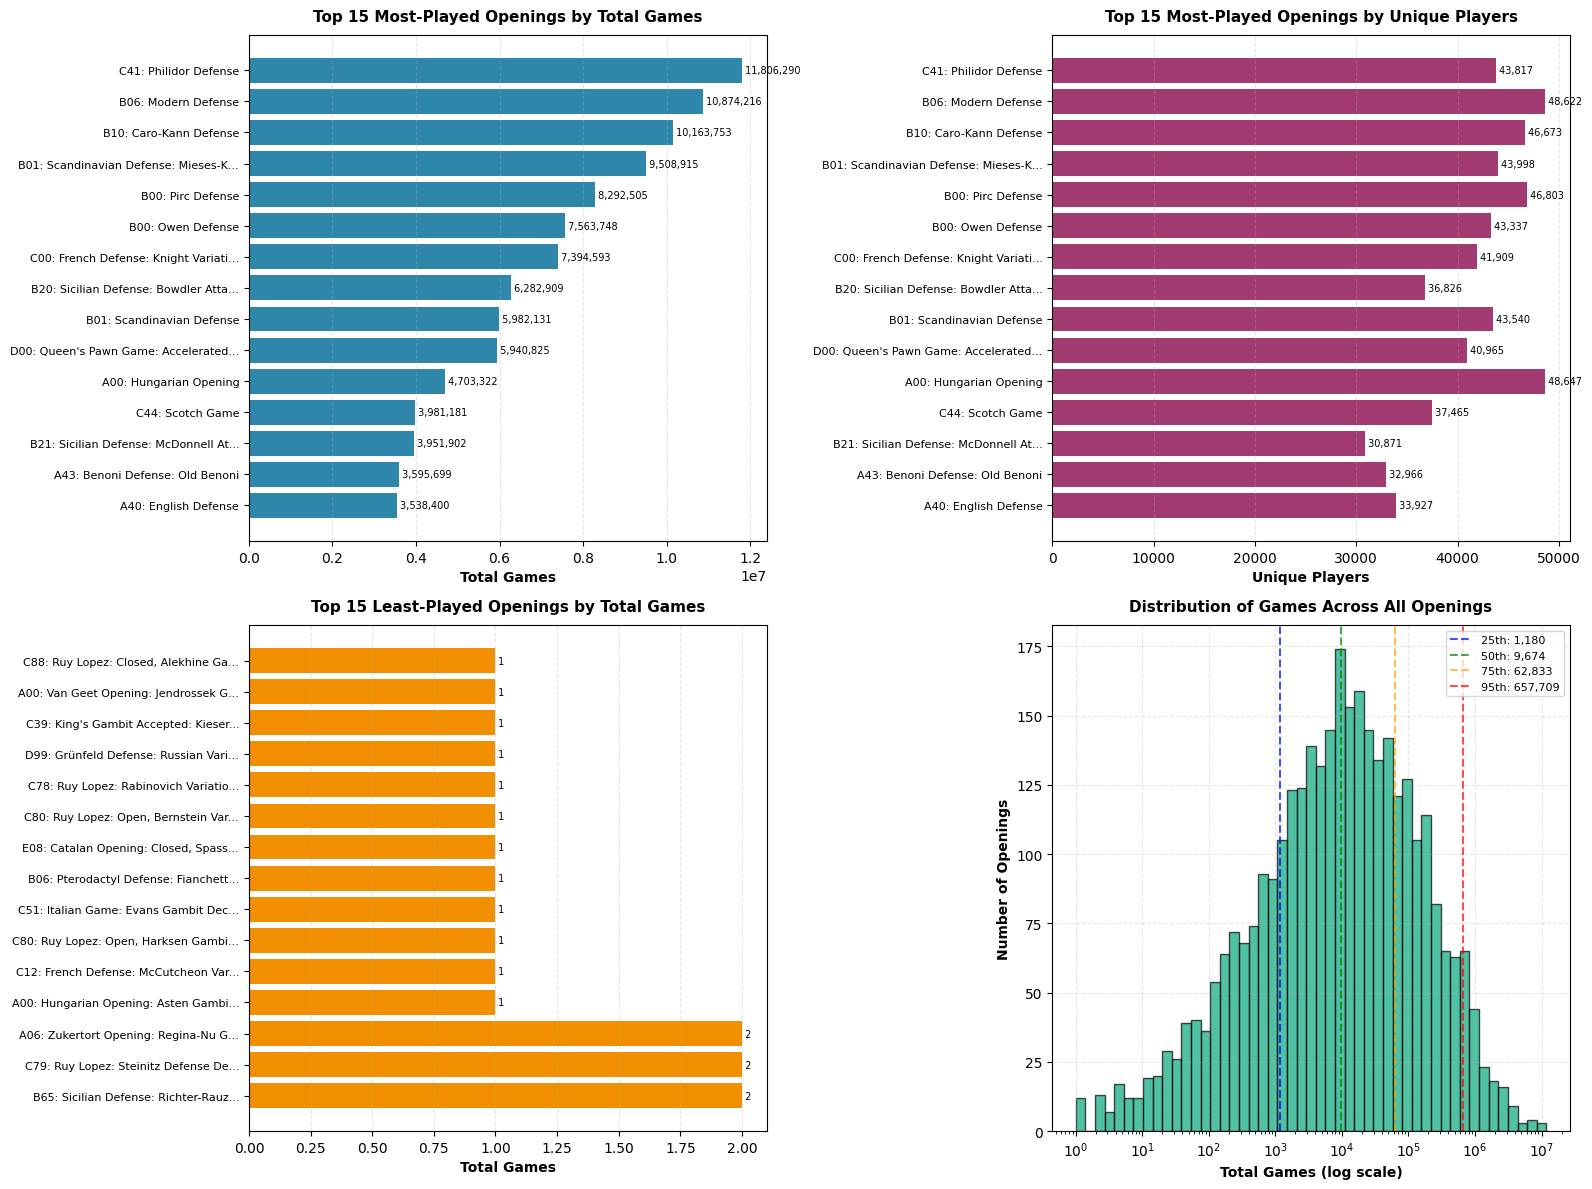

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Chart saved to: notebooks/opening_games_vs_players.png


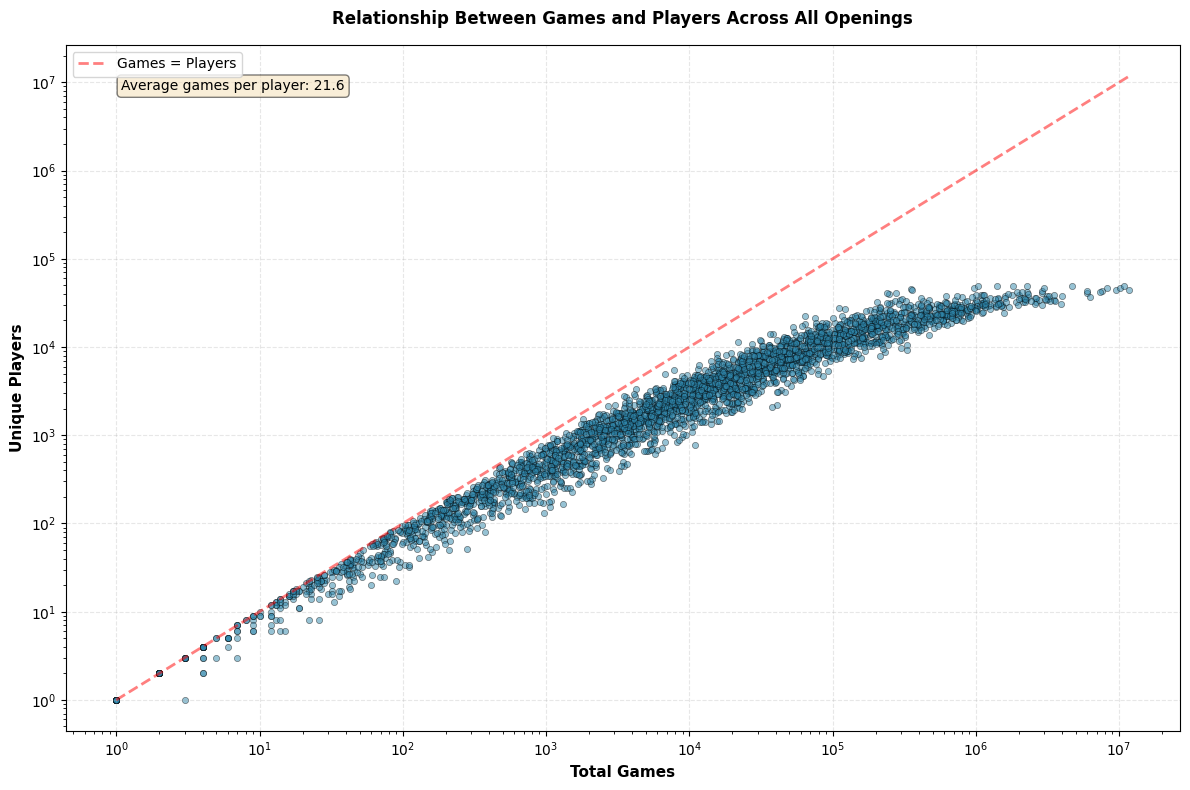


✅ All visualizations generated successfully!


In [40]:
# Visualize opening popularity with charts
import matplotlib.pyplot as plt
import numpy as np

if db_path.exists():
    with get_db_connection(db_path) as con:
        print("=== GENERATING OPENING POPULARITY VISUALIZATIONS ===\n")
        
        # Get data for most-played openings
        most_played_viz = con.execute(f"""
            SELECT 
                o.eco || ': ' || SUBSTRING(o.name, 1, 30) || 
                    CASE WHEN LENGTH(o.name) > 30 THEN '...' ELSE '' END as opening_label,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                COUNT(DISTINCT pos.player_id) as unique_players
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id, o.eco, o.name
            ORDER BY total_games DESC
            LIMIT {TOP_N_MOST_PLAYED}
        """).fetchdf()
        
        # Get data for least-played openings
        least_played_viz = con.execute(f"""
            SELECT 
                o.eco || ': ' || SUBSTRING(o.name, 1, 30) || 
                    CASE WHEN LENGTH(o.name) > 30 THEN '...' ELSE '' END as opening_label,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                COUNT(DISTINCT pos.player_id) as unique_players
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id, o.eco, o.name
            ORDER BY total_games ASC
            LIMIT {TOP_N_LEAST_PLAYED}
        """).fetchdf()
        
        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Top Most-Played Openings by Games
        ax1 = plt.subplot(2, 2, 1)
        y_pos = np.arange(min(15, len(most_played_viz)))
        bars1 = ax1.barh(y_pos, most_played_viz['total_games'].head(15), color='#2E86AB')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(most_played_viz['opening_label'].head(15), fontsize=8)
        ax1.invert_yaxis()
        ax1.set_xlabel('Total Games', fontsize=10, fontweight='bold')
        ax1.set_title(f'Top 15 Most-Played Openings by Total Games', fontsize=11, fontweight='bold', pad=10)
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for i, (bar, games) in enumerate(zip(bars1, most_played_viz['total_games'].head(15))):
            ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                    f' {games:,.0f}', va='center', fontsize=7)
        
        # 2. Top Most-Played Openings by Players
        ax2 = plt.subplot(2, 2, 2)
        y_pos = np.arange(min(15, len(most_played_viz)))
        bars2 = ax2.barh(y_pos, most_played_viz['unique_players'].head(15), color='#A23B72')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(most_played_viz['opening_label'].head(15), fontsize=8)
        ax2.invert_yaxis()
        ax2.set_xlabel('Unique Players', fontsize=10, fontweight='bold')
        ax2.set_title(f'Top 15 Most-Played Openings by Unique Players', fontsize=11, fontweight='bold', pad=10)
        ax2.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for i, (bar, players) in enumerate(zip(bars2, most_played_viz['unique_players'].head(15))):
            ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                    f' {players:,.0f}', va='center', fontsize=7)
        
        # 3. Least-Played Openings by Games
        ax3 = plt.subplot(2, 2, 3)
        y_pos = np.arange(min(15, len(least_played_viz)))
        bars3 = ax3.barh(y_pos, least_played_viz['total_games'].head(15), color='#F18F01')
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(least_played_viz['opening_label'].head(15), fontsize=8)
        ax3.invert_yaxis()
        ax3.set_xlabel('Total Games', fontsize=10, fontweight='bold')
        ax3.set_title(f'Top 15 Least-Played Openings by Total Games', fontsize=11, fontweight='bold', pad=10)
        ax3.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for i, (bar, games) in enumerate(zip(bars3, least_played_viz['total_games'].head(15))):
            ax3.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                    f' {games:,.0f}', va='center', fontsize=7)
        
        # 4. Distribution histogram - all openings
        all_games = con.execute("""
            SELECT SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id
        """).fetchdf()
        
        ax4 = plt.subplot(2, 2, 4)
        # Use log scale for better visualization of the distribution
        bins = np.logspace(np.log10(all_games['total_games'].min()), 
                          np.log10(all_games['total_games'].max()), 
                          50)
        ax4.hist(all_games['total_games'], bins=bins, color='#06A77D', alpha=0.7, edgecolor='black')
        ax4.set_xscale('log')
        ax4.set_xlabel('Total Games (log scale)', fontsize=10, fontweight='bold')
        ax4.set_ylabel('Number of Openings', fontsize=10, fontweight='bold')
        ax4.set_title('Distribution of Games Across All Openings', fontsize=11, fontweight='bold', pad=10)
        ax4.grid(axis='both', alpha=0.3, linestyle='--')
        
        # Add percentile lines
        percentiles = [25, 50, 75, 95]
        percentile_values = [all_games['total_games'].quantile(p/100) for p in percentiles]
        colors_p = ['blue', 'green', 'orange', 'red']
        
        for p, val, color in zip(percentiles, percentile_values, colors_p):
            ax4.axvline(val, color=color, linestyle='--', linewidth=1.5, alpha=0.7, 
                       label=f'{p}th: {val:,.0f}')
        
        ax4.legend(fontsize=8, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(project_root / 'notebooks' / 'opening_popularity_analysis.png', 
                   dpi=150, bbox_inches='tight')
        print("✓ Chart saved to: notebooks/opening_popularity_analysis.png")
        plt.show()
        
        # Create a second figure for games vs players scatter plot
        fig2 = plt.figure(figsize=(12, 8))
        
        # Get data for all openings
        all_openings = con.execute("""
            SELECT 
                o.eco,
                o.name,
                SUM(pos.num_wins + pos.num_draws + pos.num_losses) as total_games,
                COUNT(DISTINCT pos.player_id) as unique_players
            FROM opening o
            JOIN player_opening_stats pos ON o.id = pos.opening_id
            GROUP BY o.id, o.eco, o.name
        """).fetchdf()
        
        ax = plt.subplot(1, 1, 1)
        scatter = ax.scatter(all_openings['total_games'], 
                           all_openings['unique_players'],
                           alpha=0.5, s=20, c='#2E86AB', edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel('Total Games', fontsize=11, fontweight='bold')
        ax.set_ylabel('Unique Players', fontsize=11, fontweight='bold')
        ax.set_title('Relationship Between Games and Players Across All Openings', 
                    fontsize=12, fontweight='bold', pad=15)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add reference line (games = players)
        min_val = min(all_openings['total_games'].min(), all_openings['unique_players'].min())
        max_val = max(all_openings['total_games'].max(), all_openings['unique_players'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=2, 
               label='Games = Players')
        
        ax.legend(fontsize=10)
        
        # Add text annotation
        avg_games_per_player = all_openings['total_games'].sum() / all_openings['unique_players'].sum()
        ax.text(0.05, 0.95, f'Average games per player: {avg_games_per_player:.1f}',
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(project_root / 'notebooks' / 'opening_games_vs_players.png', 
                   dpi=150, bbox_inches='tight')
        print("✓ Chart saved to: notebooks/opening_games_vs_players.png")
        plt.show()
        
        print("\n✅ All visualizations generated successfully!")
        
else:
    print(f"Database file not found at {db_path}")

## Top Performing Openings by Win Rate

Let's analyze the highest win-rate openings to identify the most successful openings in the database. We'll look at:
- Overall win percentage (combined white and black)
- Win rate when playing as White
- Win rate when playing as Black
- Supporting data: number of games and unique players for each opening